In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import time
from functions import*

In [2]:
# Define an RBF (Gaussian) Kernel
def rbf_kernel(X1, X2, length_scale=0.1, sigma_f=1.0):
    """Computes the RBF kernel matrix."""
    sq_dist = cdist(X1, X2, 'sqeuclidean')
    return sigma_f ** 2 * np.exp(-sq_dist / (2 * length_scale ** 2))

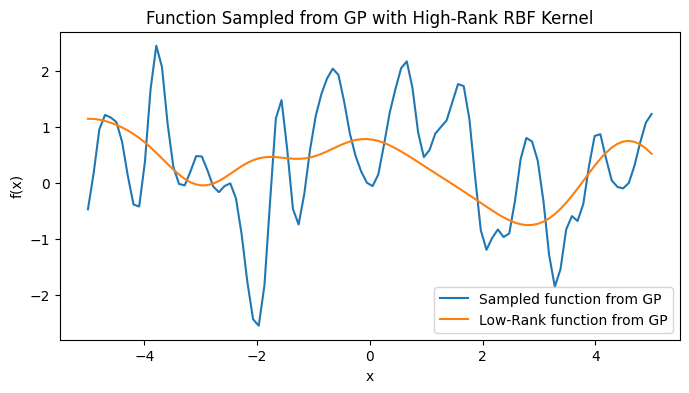

In [3]:
# Generate input points
X = np.linspace(-5, 5, 10**2).reshape(-1, 1)

# Compute kernel matrix (covariance matrix for the GP)
K = rbf_kernel(X, X, length_scale=0.2)
K_low_rank = rbf_kernel(X, X, length_scale=1)

# Sample from a Gaussian Process (mean=0, covariance=K)
f_samples = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K)
f_samples_low_rank = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K_low_rank)

# Plot the sampled function
plt.figure(figsize=(8, 4))
plt.plot(X, f_samples, label="Sampled function from GP")
plt.plot(X, f_samples_low_rank, label="Low-Rank function from GP")
plt.title("Function Sampled from GP with High-Rank RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [4]:
class GPfunctions_noise:
    def __init__(self, K, length_scale=None, IfStationary=True):
        self.K=K
        self.num_points= 500 #number of actions
        actionspace =  np.linspace(-5,5,self.num_points) #.reshape(-1, 1) # grid points
        self.actionspace = np.sort(actionspace,axis=0)
        self.length_scale=length_scale
        # Compute covariance matrix
        if IfStationary == True:
            self.kernel = self.rbf_kernel()
        else:
            self.kernel = self.gibbs_kernel()
        self.noise_var=1e-2
        self.subset = self.algorithm()

    # Stationary Gaussian Kernel
    def rbf_kernel(self):
        """Computes the RBF kernel matrix."""
        actionset=self.actionspace.reshape((-1,1))
        sq_dist = cdist(actionset,actionset, 'sqeuclidean')
        return np.exp(-sq_dist / (2 * self.length_scale ** 2))
    
    def samples(self,size):
        # Sample multiple functions from the GP
        return np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel,size=size)
    
    # def argmax(self,f_samples,N):
    #     cts = GaussianCTS(self.num_points, budget=1, prior_var=1.0, noise_var=self.noise_var)
    #     for t in range(N):
    #         # Y_samples = f_samples + np.random.normal(loc=0.0, scale=self.noise_var, size=(1,self.num_points))
    #         selected_actions = cts.step(f_samples[0,:])
    #     return selected_actions  

    # def algorithm(self):
    #     subset=np.array([], dtype=int)
    #     while len(subset) < self.K: # add more items until K distinct actions are found
    #         f_samples = self.samples(size=1) #(size=min(1,self.K-len(subset)))
    #         max_indices = self.argmax(f_samples, N=500)  #np.argmax(f_samples, axis=1)
    #         subset = np.unique(np.append(subset,max_indices))
    #     return subset

    def argmax(self, f_samples, N):
        cts = GaussianCTS(self.num_points, budget=1, prior_var=1.0, noise_var=self.noise_var)
        for t in range(N-1):  # only update internal state
            _ = cts.step(f_samples[0,:])
        selected_actions = cts.step(f_samples[0,:])  # final result
        return selected_actions

    def algorithm(self):
        subset = set()
        samplesize=0
        while len(subset) < self.K:
            f_samples = self.samples(size=self.K - len(subset))
            for f in f_samples:
                max_indices = self.argmax(f[np.newaxis, :], N=300)
                samplesize+=300
                subset.update(max_indices)
        self.epsilon_samplesize = samplesize
        return np.array(list(subset))
    
    def test(self,subset):
        num_batches = 10**5  # Number of function samples for testing
        # Sample multiple functions from the GP
        f_samples = self.samples(size=num_batches) # np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        return np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,subset], axis=1))

    def ucb_action_selection(self, N):
        """
        Selects a subset of K actions using Upper Confidence Bound (UCB).
        Returns: List of selected action indices.
        """
        # Sample multiple functions from the GP
        f_samples = self.samples(size=N) 
        ucb = CombinatorialUCB(self.num_points, self.K, noise_var=self.noise_var)

        for t in range(N):
            selected_actions = ucb.step(f_samples[t,:])
        return selected_actions
    
    def ts_action_selection(self, N):
        """
        Selects a subset of K actions using Thompson Sampling.
        Returns: List of selected action indices.
        """
        # Sample multiple functions from the GP
        f_samples = self.samples(size=N) 
        
        cts = GaussianCTS(self.num_points, self.K, prior_var=1.0, noise_var=self.noise_var)

        for t in range(N):
            selected_actions = cts.step(f_samples[t,:])
        return selected_actions  

In [5]:
# Example: create an instance
gp = GPfunctions_noise(K=10, length_scale=2.0)

# Measure runtime of a method
start_time = time.time()
subset = gp.algorithm()
end_time = time.time()
print(f"algorithm() runtime: {end_time - start_time:.4f} seconds")

print(f"algorithm() sample size: {gp.epsilon_samplesize}")

# Measure runtime for ucb_action_selection
start_time = time.time()
ucb_actions = gp.ucb_action_selection(N=2000)
end_time = time.time()
print(f"ucb_action_selection() runtime: {end_time - start_time:.4f} seconds")

# Measure runtime for ts_action_selection
start_time = time.time()
ts_actions = gp.ts_action_selection(N=3000)
end_time = time.time()
print(f"ts_action_selection() runtime: {end_time - start_time:.4f} seconds")


algorithm() runtime: 0.2332 seconds
algorithm() sample size: 3000
ucb_action_selection() runtime: 2.9307 seconds
ts_action_selection() runtime: 0.8523 seconds


In [6]:
K=10
# Create an instance
gp = GPfunctions_noise(K=K, length_scale=2.0)

# Number of repetitions
repetitions = 30

# Store runtimes
runtimes = {
    "epsilon": [],"ts": [],"ucb": [],
}

# Store samplesize
samplesize = {
    "epsilon": [],"ts": [3000*K]*repetitions,
    "ucb": [500+2000*K]*repetitions, # UCB needs initialization
}

for i in range(repetitions):
    # Algorithm
    start_time = time.time()
    subset = gp.algorithm()
    end_time = time.time()
    runtimes["epsilon"].append(end_time - start_time)
    samplesize["epsilon"].append(gp.epsilon_samplesize)
    
    # Thompson Sampling
    start_time = time.time()
    ts_actions = gp.ts_action_selection(N=3000)
    end_time = time.time()
    runtimes["ts"].append(end_time - start_time)

    # UCB
    start_time = time.time()
    ucb_actions = gp.ucb_action_selection(N=2000)
    end_time = time.time()
    runtimes["ucb"].append(end_time - start_time)
    
# Convert to numpy array if you want easy statistics
runtimes_array = {k: np.array(v) for k, v in runtimes.items()}
samplesize_array = {k: np.array(v) for k, v in samplesize.items()}

# Print results
for key, times in runtimes_array.items():
    print(f"{key}: mean={times.mean():.4f}s, std={times.std():.4f}s, all={times}")

epsilon: mean=0.2275s, std=0.0775s, all=[0.23687935 0.1892364  0.26248479 0.23314142 0.1964097  0.20173788
 0.18979025 0.320333   0.1901257  0.21025014 0.18919563 0.19144106
 0.18865848 0.18889856 0.26844025 0.19178057 0.22999525 0.26529431
 0.19068599 0.1957624  0.18956137 0.30156326 0.19112492 0.20067358
 0.22455072 0.1897738  0.19004583 0.21813655 0.18931484 0.59928155]
ts: mean=0.3126s, std=0.0726s, all=[0.3013618  0.30489731 0.28740311 0.30249739 0.42002845 0.3265233
 0.28573465 0.30305004 0.4321599  0.36831307 0.26962209 0.30331969
 0.27088022 0.26906466 0.28720379 0.26789665 0.27417564 0.28513718
 0.27077746 0.30748963 0.2705152  0.28664207 0.27422976 0.28102756
 0.27633047 0.34525943 0.27695322 0.32083058 0.27380109 0.63623095]
ucb: mean=2.5799s, std=0.3643s, all=[2.70851326 2.44583511 2.55288982 2.83184743 2.53232193 2.52941036
 2.43188381 2.6221137  2.5612576  2.39982891 2.52478456 2.3978672
 2.61336064 2.41194749 2.42620039 2.60361862 2.46463895 2.53960061
 2.43511796 2.5453

In [15]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.5,1,1.5,2,2.5] #0.1,0.5,1,
K=10
for length_scale in length_range:
    for ignore in range(30):
        fun=GPfunctions_noise(K,length_scale=length_scale,IfStationary=IfStationary)
        output=fun.test(fun.subset)
        ucb=fun.test(fun.ucb_action_selection(N=2000))
        ts=fun.test(fun.ts_action_selection(N=3000))
        row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
        row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
        row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
        report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

# report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

In [ ]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.5,1,1.5,2,2.5] #0.1,0.5,1,

for K in [10,20]:
    for length_scale in length_range:
        for ignore in range(10):
            fun=GPfunctions_noise(K,length_scale=length_scale,IfStationary=IfStationary)
            output=fun.test(fun.subset)
            ucb=fun.test(fun.ucb_action_selection(N=500))
            ts=fun.test(fun.ts_action_selection(N=500))
            row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
            row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
            row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
            report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

# report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

In [17]:
report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

**Plots**

In [7]:
report=pd.read_csv('report_StationaryTrue.csv')
length_range=[0.5,1,1.5,2]
K=10

In [19]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts in PDF
mpl.rcParams['ps.fonttype'] = 42   # Use TrueType fonts in PS
plt.rcParams.update({'font.size': 14})

methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet+TS','Combinatorial TS','Combinatorial UCB']))
legendnames = dict(zip(methods,['EpsilonNet+TS (N=300)','Combinatorial TS (N=3000)','Combinatorial UCB (N=2000)']))
colormap = dict(zip(methods, ['#8ac926',"#E19107FF",'#ff595e'])) #['b',"#B87502FF","#F45106E7"]

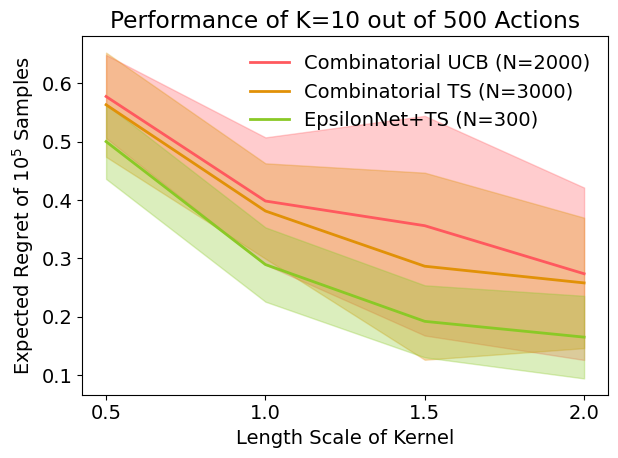

In [20]:
fig, axes = plt.subplots()  # (rows, cols)

for m in methods[::-1]:
    dfmean=report.groupby(by=["length_scale",'method']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[l][m] for l in length_range])
    dfstd=report.groupby(by=["length_scale",'method']).std()['EmpiricialRegret']
    std=np.array([dfstd[l][m] for l in length_range])
    axes.plot(length_range, mean, label="{}".format(legendnames[m]), color=colormap[m],linewidth=2)
    axes.fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.3)

# axes[i].set_ylim([0,0.7])
axes.set_title("Performance of K={} out of 500 Actions".format(K))
axes.set_xlabel("Length Scale of Kernel")
axes.set_xticks(length_range)
axes.set_ylabel(r"Expected Regret of $10^5$ Samples")
axes.legend(framealpha=0)

# Save plot as a PDF without margins
plt.savefig("RKHS_combinatorial.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

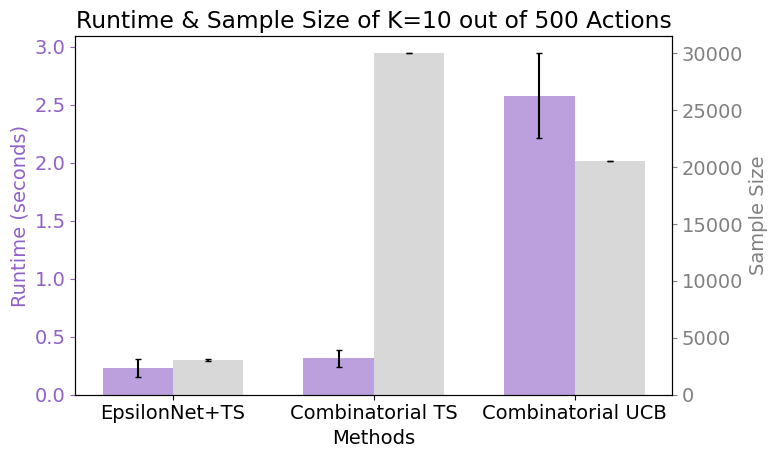

In [10]:
fig, ax1 = plt.subplots(figsize=(8, 4.8)) 

runtime_color = "#9061C8FF"
samplesize_color = "gray"

functions = list(runtimes_array.keys())
x = np.arange(len(functions))   # positions on x-axis
width = 0.35                    # width of each bar

# Runtime means & stds
means_runtime = [runtimes_array[f].mean() for f in functions]
stds_runtime = [runtimes_array[f].std() for f in functions]

# Sample size means & stds
means_samples = [samplesize_array[f].mean() for f in functions]
stds_samples = [samplesize_array[f].std() for f in functions]

# Bar positions: shift runtime left, sample size right
bars1 = ax1.bar(
    x - width/2,
    means_runtime,
    yerr=stds_runtime,
    capsize=2,
    color=runtime_color,
    alpha=0.6,
    width=width
)

ax1.set_xlabel("Methods", color='black')
ax1.set_ylabel("Runtime (seconds)", color=runtime_color)
ax1.tick_params(axis='y', colors=runtime_color)   # y-axis tick color
ax1.set_title(f"Runtime & Sample Size of K={K} out of 500 Actions")

# Second axis for sample sizes
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    means_samples,
    yerr=stds_samples,
    capsize=2,
    alpha=0.3,
    color=samplesize_color,
    width=width
)
ax2.set_ylabel("Sample Size", color=samplesize_color)
ax2.tick_params(axis='y', colors=samplesize_color)  # y-axis tick color

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels([methodnames[f] for f in functions])

# Save plot as a PDF without margins
plt.savefig("RKHS_runtime.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()


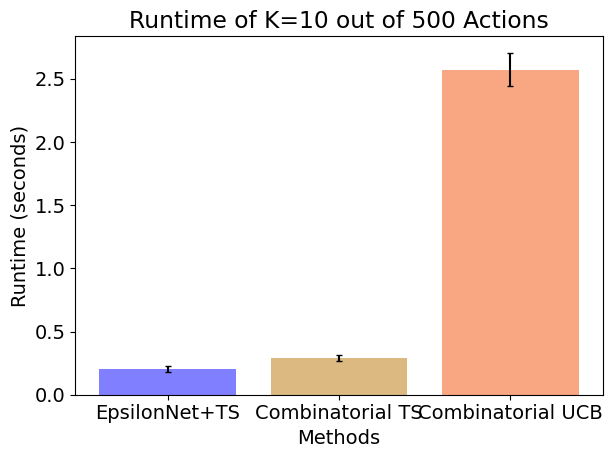

In [16]:
fig, axes = plt.subplots() 

functions = list(runtimes_array.keys())
means = [runtimes_array[f].mean() for f in functions]
stds = [runtimes_array[f].std() for f in functions]

# Plot mean ± std as error bars
axes.set_title("Runtime of K={} out of 500 Actions".format(K))
axes.bar([methodnames[key] for key in runtimes_array.keys()], means, yerr=stds, 
            capsize=2, color=[colormap[key] for key in runtimes_array.keys()],alpha=0.5)
axes.set_ylabel("Runtime (seconds)")
axes.set_xlabel("Methods")

# Save plot as a PDF without margins
plt.savefig("RKHS_runtime.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

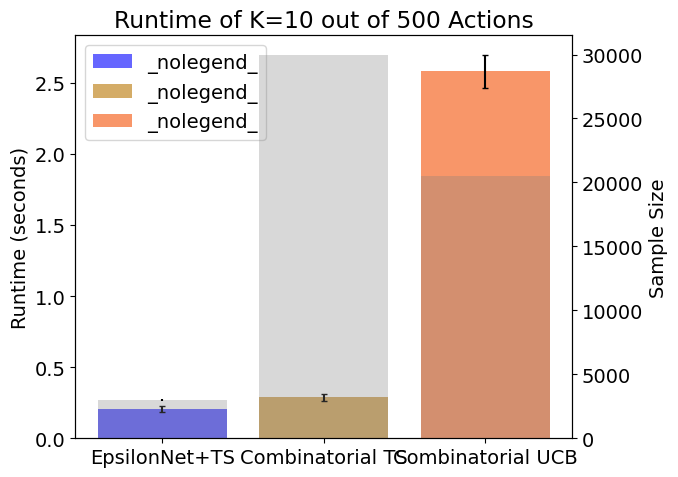

In [31]:
fig, ax1 = plt.subplots(figsize=(7,5)) 

functions = list(runtimes_array.keys())
means = [runtimes_array[f].mean() for f in functions]
stds = [runtimes_array[f].std() for f in functions]

# First axis: runtime
ax1.set_title(f"Runtime of K={K} out of 500 Actions")
bars1 = ax1.bar(
    [methodnames[key] for key in functions],
    means,
    yerr=stds,
    capsize=2,
    color=[colormap[key] for key in functions],
    alpha=0.6,
    label="Runtime"
)
ax1.set_ylabel("Runtime (seconds)", color="black")

functions = list(samplesize_array.keys())
means = [samplesize_array[f].mean() for f in functions]
stds = [samplesize_array[f].std() for f in functions]

# Second axis: sample size
ax2 = ax1.twinx()
bars2 = ax2.bar(
    [methodnames[key] for key in functions],
    means,
    yerr=stds,
    alpha=0.3,
    color="gray"
)
ax2.set_ylabel("Sample Size", color="black")

# Add legends
bars = bars1
labels = [b.get_label() for b in bars]
ax1.legend(bars, labels, loc="upper left")

# Save plot as a PDF without margins
# plt.savefig("RKHS_runtime.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

plt.tight_layout()
plt.show()


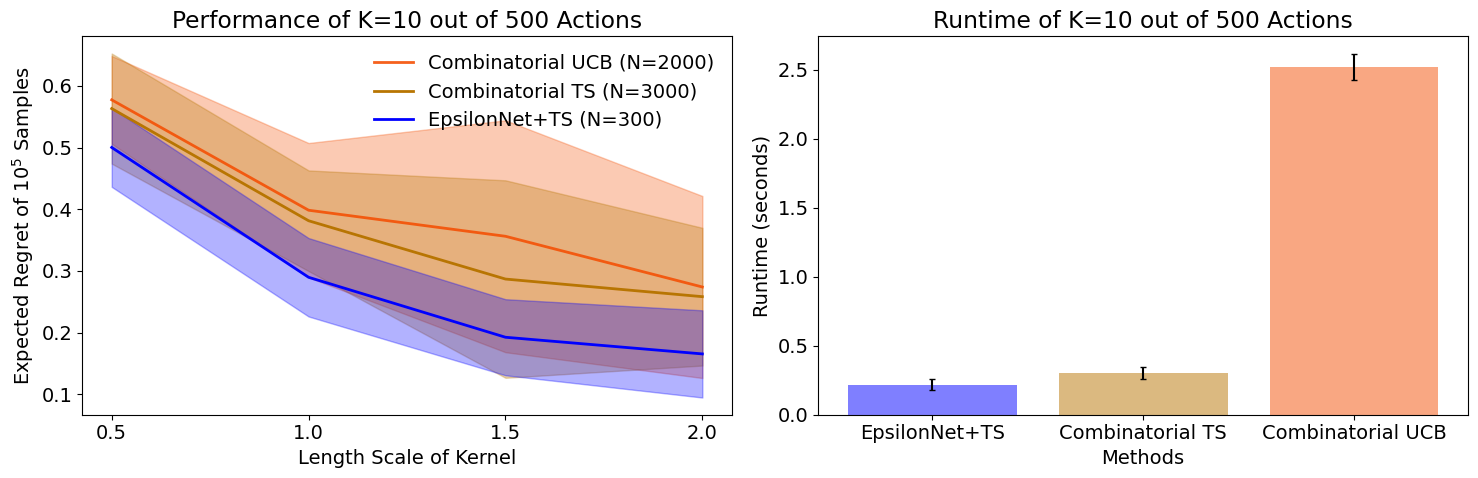

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet+TS','Combinatorial TS','Combinatorial UCB']))
legendnames = dict(zip(methods,['EpsilonNet+TS (N=300)','Combinatorial TS (N=3000)','Combinatorial UCB (N=2000)']))
colormap = dict(zip(methods, ['b',"#B87502FF","#F45106E7"]))

i=0
for m in methods[::-1]:
    dfmean=report.groupby(by=["length_scale",'method']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[l][m] for l in length_range])
    dfstd=report.groupby(by=["length_scale",'method']).std()['EmpiricialRegret']
    std=np.array([dfstd[l][m] for l in length_range])
    axes[i].plot(length_range, mean, label="{}".format(legendnames[m]), color=colormap[m],linewidth=2)
    axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.3)

# axes[i].set_ylim([0,0.7])
axes[i].set_title("Performance of K={} out of 500 Actions".format(K))
axes[i].set_xlabel("Length Scale of Kernel")
axes[i].set_xticks(length_range)
axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
axes[i].legend(framealpha=0)

i=1
functions = list(runtimes_array.keys())
means = [runtimes_array[f].mean() for f in functions]
stds = [runtimes_array[f].std() for f in functions]

# Plot mean ± std as error bars
axes[i].set_title("Runtime of K={} out of 500 Actions".format(K))
axes[i].bar([methodnames[key] for key in runtimes_array.keys()], means, yerr=stds, 
            capsize=2, color=[colormap[key] for key in runtimes_array.keys()],alpha=0.5)
axes[i].set_ylabel("Runtime (seconds)")
axes[i].set_xlabel("Methods")

# Save plot as a PDF without margins
plt.savefig("RKHS_combinatorial.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

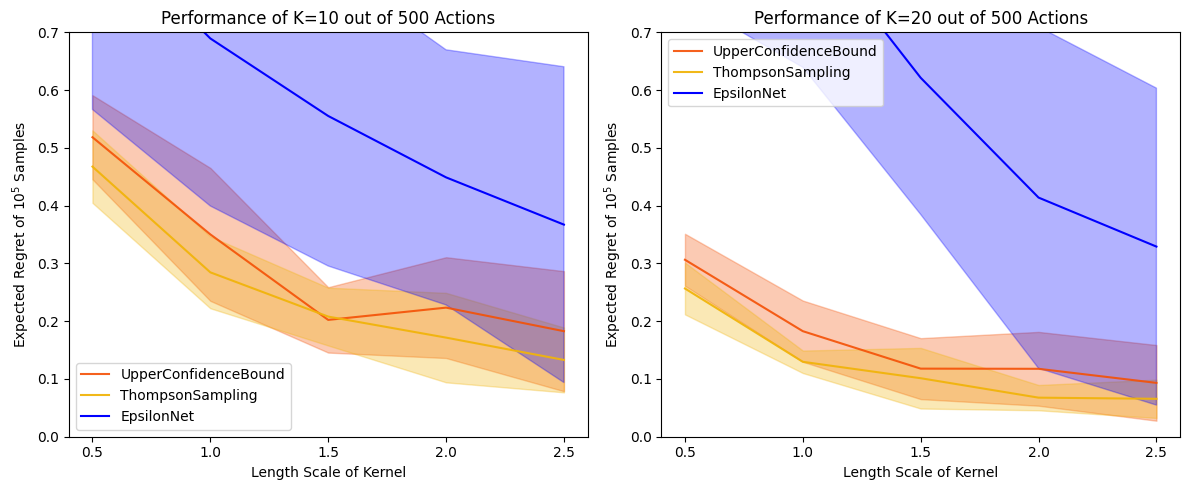

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [10,20]
colormap = dict(zip(methods, ['b',"#F1B40BF1","#F45106E7"]))

for i in range(2):
    for m in methods[::-1]:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m])
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.3)

    axes[i].set_ylim([0,0.7])
    axes[i].set_title("Performance of K={} out of 500 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend()

# Save plot as a PDF without margins
# plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

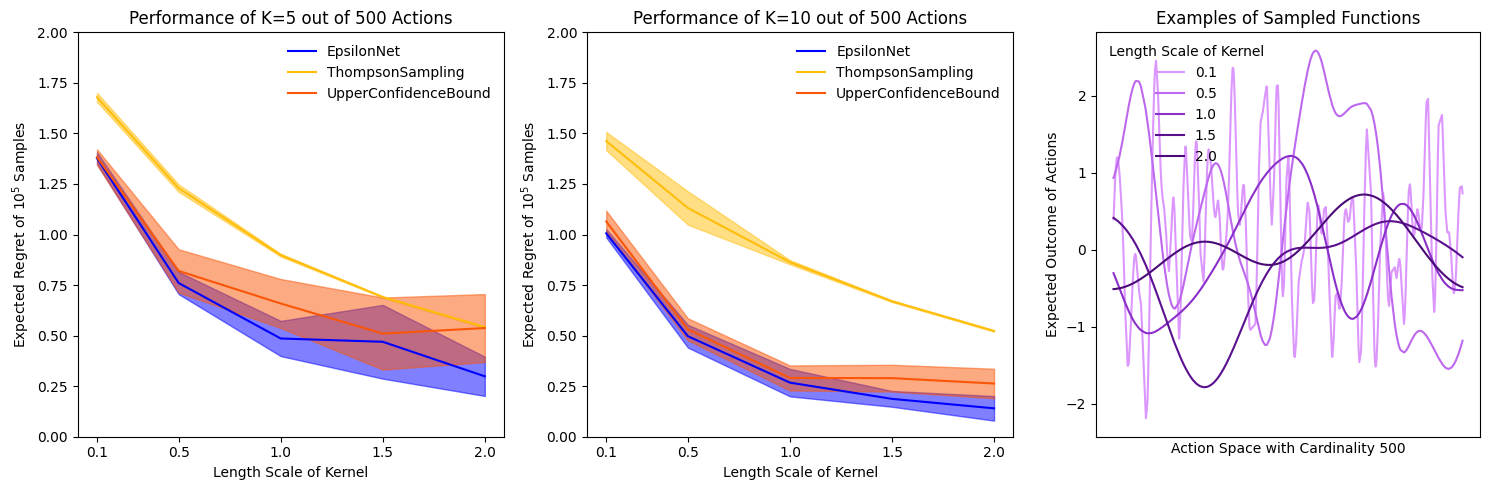

In [68]:
fig, axes = plt.subplots(1,3,figsize=(15, 5), gridspec_kw={'width_ratios': [1,1,0.9]})  # (rows, cols)
# plt.subplots_adjust(wspace=0, hspace=0)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [5,10]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
colormap_sample = dict(zip(length_range, ['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m])
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([0,2])
    axes[i].set_title("Performance of K={} out of 500 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend(frameon=False)

i=2
for l in length_range:
    fun=GPfunctions(1,l)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap_sample[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',frameon=False)

# Save plot as a PDF without margins
plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

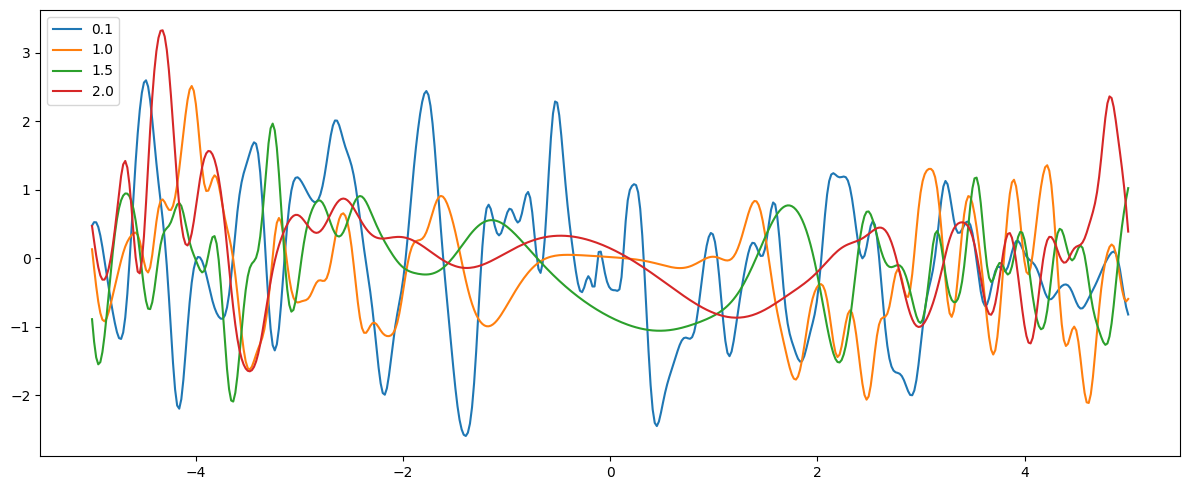

In [93]:
fig, axes = plt.subplots(figsize=(12, 5))  # (rows, cols)

for l in [0.1,1,1.5,2]:
    fun=GPfunctions(1,l,IfStationary=False)
    axes.plot(fun.actionspace,fun.samples(size=1).reshape(-1),label="{:.1f}".format(l))

plt.legend()
# Adjust layout
plt.tight_layout()
plt.show()

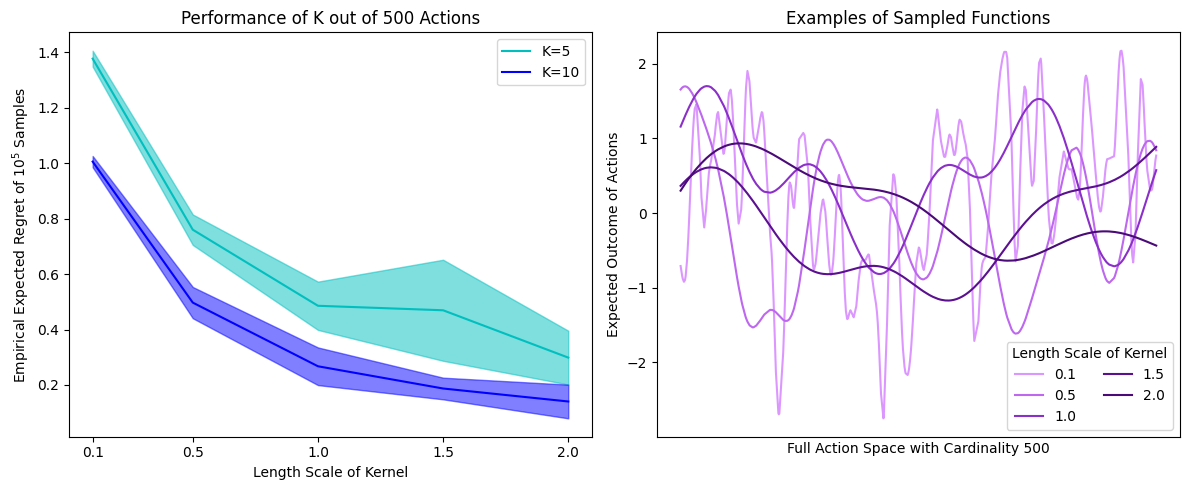

In [32]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
colormap = dict(zip([5,10]+length_range, ['c','b']+['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

i=0
for K in [5,10]:
    dfmean=report_ep.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[i][K] for i in length_range])
    dfstd=report_ep.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
    std=np.array([dfstd[i][K] for i in length_range])
    axes[i].plot(length_range, mean, label="K={}".format(K), color=colormap[K])
    axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[K],alpha=0.5)

# axes[i].set_ylim([0,1.5])
axes[i].set_title("Performance of K out of 500 Actions")
axes[i].set_xlabel("Length Scale of Kernel")
axes[i].set_xticks(length_range)
axes[i].set_ylabel(r"Empirical Expected Regret of $10^5$ Samples")
axes[i].legend()

i=1
for l in length_range:
    fun=GPfunctions(1,l,actionspace=actionspace)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Full Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',ncol=2)

# Save plot as a PDF without margins
# plt.savefig("RKHS.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [337]:
def thompson_sampling_action_selection(alpha, beta, K=5):
    """
    Selects a subset of K actions using Thompson Sampling.
    
    alpha, beta: Parameters of the Beta distribution for each action.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    sampled_values = np.random.beta(alpha, beta)  # Sample from Beta distribution
    selected_actions = np.argsort(sampled_values)[-K:]  # Select top K actions
    return selected_actions

# Example usage
num_actions = 10
alpha = np.ones(num_actions)  # Prior successes (initialize as 1)
beta = np.ones(num_actions)   # Prior failures (initialize as 1)
selected_actions = thompson_sampling_action_selection(alpha, beta, K=5)

print("Selected actions using Thompson Sampling:", selected_actions)

Selected actions using Thompson Sampling: [2 5 6 0 7]


In [338]:
def ucb_action_selection(Q, N, t, c=1.0, K=5):
    """
    Selects a subset of K actions using Upper Confidence Bound (UCB).
    
    Q: Estimated rewards for each action.
    N: Number of times each action has been selected.
    t: Current time step.
    c: Exploration-exploitation trade-off parameter.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    ucb_values = Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5))  # Avoid division by zero
    selected_actions = np.argsort(ucb_values)[-K:]  # Top K actions with highest UCB
    return selected_actions

# Example usage
num_actions = 10
Q = np.random.rand(num_actions)  # Random estimated rewards
N = np.ones(num_actions)  # Initialize with 1 to avoid division by zero
t = 100  # Current time step
selected_actions = ucb_action_selection(Q, N, t, K=5)

print("Selected actions using UCB:", selected_actions)


Selected actions using UCB: [2 8 9 0 1]


In [194]:


dfmean=report.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
mean=np.array([dfmean[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])
dfstd=report.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
std=np.array([dfstd[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])



In [277]:
report.groupby(by=["length_scale",'K']).mean()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.968969
             10.0          0.658666
0.2          5.0           0.969845
             10.0          0.612436
0.5          5.0           0.664523
             10.0          0.370710
1.0          5.0           0.515914
             10.0          0.279531
1.5          5.0           0.404753
             10.0          0.112570
2.0          5.0           0.258277
             10.0          0.106087

In [278]:
report.groupby(by=["length_scale",'K']).std()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.008003
             10.0          0.031927
0.2          5.0           0.055027
             10.0          0.108203
0.5          5.0           0.080587
             10.0          0.053958
1.0          5.0           0.117663
             10.0          0.056348
1.5          5.0           0.069309
             10.0          0.059978
2.0          5.0           0.086438
             10.0          0.048114